# トピックモデルで４人の小説家の小説を分類

## 初期設定

In [0]:
# Mecabや諸々インストール
!apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab

# 追加辞書インストール
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n

# 辞書を mecab-ipadic-NEologdに変更
#「/etc/mecabrc」ファイルの「dicdir = /var/lib/mecab/dic/debian」を、
#「mecab-ipadic-NEologd」の辞書のパス「/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd」に変更する。
!sed -i -e "s!/var/lib/mecab/dic/debian!/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd!g" /etc/mecabrc

# swingインストール
!apt-get -q -y install swig

# mecab-python3をインストール
!pip install mecab-python3

# gensimのインストール
!pip install gensim

# 日本語フォントのインストール
!apt-get -y install fonts-ipafont-gothic

## Pythonライブラリのインストール

In [0]:
import itertools
import random
import MeCab
from urllib import request 
import re
import numpy as np
import pandas as pd
import os
from gensim import corpora, models
import pickle
from wordcloud import WordCloud
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
%matplotlib inline

## 対象データの読み込み  
梶井基次郎: 45作品  
永井荷風:   85作品  
中島敦:     27作品  
夏目漱石:   104作品

In [3]:
# google driveよりファイル取り出し
file_name = '/content/drive/My Drive/novel_list.pickle'
pickle_dic = open(file_name, 'rb')
novel_df = pickle.load(pickle_dic)
pickle_dic.close

# モデリング結果との連結キーとしてID列追加
id_list = []
for i in range(len(novel_df)):
  ID = 'ID_' + str(i)
  id_list.append(ID)

novel_df['ID'] = id_list

# データをランダムに入れ替え
novel_df = novel_df.sample(frac=1, random_state=0)
novel_df.head(5)

,title,content,author,ID
166,教育と文芸,\n\n 私は思いがけなく前から当地の教育会の御招待を受けました。凡《およ》そ一カ月前に御通...,3,ID_166
106,十九の秋,\n\n 近年新聞紙の報道するところについて見るに、東亜の風雲はますます急となり、日支同文の...,1,ID_106
239,作物の批評,\n\n 中学には中学の課目があり、高等学校には高等学校の課目があって、これを修了せねば卒業...,3,ID_239
76,放水路,\n\n 隅田川《すみだがわ》の両岸は、千住《せんじゅ》から永代《えいたい》の橋畔《きょうは...,1,ID_76
220,京に着ける夕,\n\n 汽車は流星の疾《はや》きに、二百里の春を貫《つらぬ》いて、行くわれを七条《しちじょ...,3,ID_220


## 対象データの前処理とTokenizerの用意  
#### Doc2Vec.ipynb と行うことは同じ

In [0]:
# 日本語ストップワードのダウンロード
res = request.urlopen("http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt")
stopwords = [line.decode("utf-8").strip() for line in res]

# 英語ストップワードのダウンロード
res = request.urlopen("http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/English.txt")
stopwords += [ line.decode("utf-8").strip() for line in res]

In [0]:
# 分かち書きして、対象単語のみ取り出すTokenizerクラスの作成
# 処理内容
#   英単語を小文字に変える
#   分かち書きする
#   名詞、動詞、形容詞のみ抽出
#   ストップワードを除外する
#   ※上記処理後の結果を見て追加処理考える

class Tokenizer:

    def __init__(self, stopwords, parser=None, include_pos=None, exclude_posdetail=None, exclude_reg=None):
        '''
        stopwords: ストップワードのリスト
        parser: mecabがデフォルト。別のパーサーを指定したときに利用
        include_pos: 抽出対象の品詞リスト。デフォルトは、['名詞', '動詞', '形容詞']
        exclude_posdetail: 除外対象の詳細品詞("固有名詞"とか、"格助詞"など)。デフォルトは、['接尾', '数']
        exclude_reg: 除外対象文字を正規表現で指定できる。例) r"\d(年|月|日) 指定で年月日を削除できる。
        '''
        self.stopwords = stopwords
        self.include_pos = include_pos if include_pos else ['名詞', '動詞', '形容詞']
        self.exclude_posdetail = exclude_posdetail if exclude_posdetail else ['接尾', '数']
        self.exclude_reg = exclude_reg if exclude_reg else r"$^"

        if parser:
            self.parser = parser
        else:
            # MeCab.Tager("-Ochasen")指定すると、分かち書き結果の出力形式が -Ochasen 無しと異なるので注意
            mecab = MeCab.Tagger('-Ochasen -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd')
            self.parser = mecab.parse

    
    def tokenize(self, text, show_pos=False):
        '''
        - 引数の記事本文から、対象単語のリストを抽出して返す。
        text: 一つの記事
        show_pos: 単語の品詞も同時に表示するかの指定。
            False: 単語のみのリスト
            True: (単語, 品詞)のタプルのリストになる。
        '''
        text = text.lower() # 英字の小文字化
        text = re.sub(r"([0-9０-９])", "", text) # 半角、全角数字の削除

        # 文章をMeCab.parseでパースしたのを改行(\n)でパースして一行毎にし、それをさらにタブ(\t)でsplitしてリスト化する。
        # l の中身：textが、'メカブって神ってる' の場合
        # [
        #    ['メカブ', 'メカブ', 'MeCab', '名詞-固有名詞-一般', '', ''],
        #    ['って', 'ッテ', 'って', '助詞-格助詞-連語', '', ''],
        #    ['神ってる', 'カミッテル', '神ってる', '名詞-固有名詞-一般', '', ''],
        #    ['EOS'],
        #    ['']
        # ]
        l = [line.split("\t") for line in self.parser(text).split("\n")]

        # lから一行(単語一つのパース結果のリスト)ずつ取り出し、
        # そのリストの要素数が4つ以上なら、品詞のある単語なので、抽出チェックする
        # i ：単語一つのパース結果のリスト：['神ってる', 'カミッテル', '神ってる', '名詞-固有名詞-一般', '', '']
        # i[2] : 単語自身
        # i[3] : 単語の品詞： '名詞-固有名詞-一般'
        # i[3].split("-")[0] in self.include_pos : 単語の品詞が対象かのチェック
        # i[3].split("-")[1] not in self.exclude_posdetail : 単語の詳細品詞が、除外対象かチェック
        # not re.search(r"(-|−)\d", i[2]) : 単語が -数字, −数字 なら除外
        # not re.search(self.exclude_reg, i[2]) : 単語が除外正規表現に当てはまるかのチェック
        # i[2] not in self.stopwords : 単語がストップワードかのチェック
        # res 中身例１（show_pos=Falseの時)：['MeCab', 'って', '神ってる']
        # res 中身例２（show_pos=Trueの時)：[('MeCab', '名詞-固有名詞-一般'), ('って', '助詞-格助詞-連語'), ('神ってる', '名詞-固有名詞-一般')]        
        res = [
            i[2] if not show_pos else (i[2], i[3]) for i in l
                if len(i) >= 4 # 品詞があるとき
                    and i[3].split("-")[0] in self.include_pos
                    and i[3].split("-")[1] not in self.exclude_posdetail
                    and not re.search(r"(-|−)\d", i[2])
                    and not re.search(self.exclude_reg, i[2])
                    and i[2] not in self.stopwords
        ] 
        return res

## モデリングと評価  
### 1.   全小説をTokenizer.tokenize()メソッドでパースして、docsリストに入れる  
### 2.   corpora.Dictionary()で、単語とIDをマッピング  
### 3.   filter_extremes()で、単語をフィルタリング
### 4.   doc2bow()で、LDAに使うコーパスを作る    
### 5.   トピックの数を変化させて、最適なトピック数を求める(各PerplexityとCoherenceを求めてグラフ化) （今回は小説家４人なのでトピック数は４） 
### 6.   5.で求めた最適なトピック数でトピックモデルを作成する

### 1.   全小説をTokenizer.tokenize()メソッドでパースして、docsリストに入れる

In [39]:
# Tokenizer()インスタンスを作成
# ここで、追加のストップワードを追加。（適時調整）
t = Tokenizer(stopwords + ["…。", "ーー", "＃", "字下げ", "は中見出し", "「", "」", "一", "［", "］", "わたくし", "僕", "來"])

# 全小説をTokenizer.tokenize()メソッドでパースして、docsリストに入れる
docs_list = []
for i, record in novel_df.iterrows():
    docs_list.append(t.tokenize(record['content'])) # contentのパース

# 確認
print("docs_list: ", docs_list[0][:10])

docs_list:  ['思いがけない', '当地', '教育', '招待', '受ける', '凡', 'そ', '通知', 'ある', 'なる']


### 2.   corpora.Dictionary()で、単語とIDをマッピング

In [0]:
# 単語とIDをマッピングさせる
d = corpora.Dictionary(docs_list)

In [31]:
d

### 3.   filter_extremes()で、単語をフィルタリング  
##### ・全ての小説に使われるような一般的な単語のフィルタリング  
##### ・各トピックの特徴を表すための単語の抽出

In [0]:
# 出現単語をフィルタリングする
# 引数の意味
# no_below: 『出現文書数 >= 指定値』になるような単語のみ保持する（同一文書内での出現頻度は関係ない）
# no_above: 『出現文書数/全文書 <= 指定値』になるような単語のみ保持する（同一文書内での出現頻度は関係ない）- 全体の何割の小説にでているか
# 使われている文書の数が、no_belowより少ない単語を無視し、no_aboveの割合以上の文書に出てくる単語を無視する。

# 最低でも４つ以上の小説に出てくる単語を抽出し、また、全小説の２割以下の小説に出ている単語
d.filter_extremes(no_below=4, no_above=0.2)

### 4.   doc2bow()で、LDAの学習に使うコーパスを作る

In [53]:
# doc2bow()で、コーパス作成
corpus = [d.doc2bow(w) for w in docs_list]

corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

### 5. トピックの数を変化させて、最適なトピック数を求める(各PerplexityとCoherenceを求めてグラフ化)   
####今回は小説家が４人なのでトピック数は４だが、本来トピックモデルでは、最適なトピック数は文章内容に異なるので、PerPlexityとCoherenceを求めて、最適なトピック数を求めるらしい。  
・Perplexity：予測性能（数学的な分類正確性）  
・Coherence：トピックの品質（人間が判断できるような分け方になっているか)  
＞公式に基づき分類が数学的に正確と言われても、その分類が人間からみて意味の無い分類なら全く意味をなさないので、上記２つの指標のバランスを取るところでトピック数を決める。

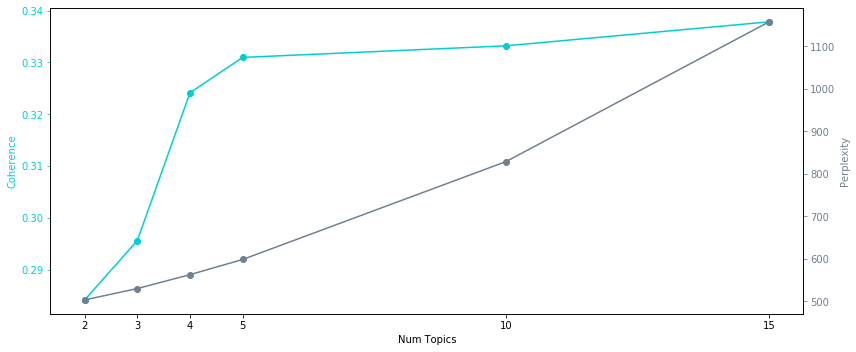

In [54]:
# 補足
# ※　PerPlexityとCoherence計算用

#　以下のトピック数でモデルを作成し、PerplexityとCohirenceの変化を見る
topic_list = [2, 3, 4, 5, 10, 15]

coherence_vals = []
perplexity_vals = []

for n_topic in topic_list:
    lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word=d, num_topics=n_topic, random_state=0)
    perplexity_vals.append(np.exp2(-lda_model.log_perplexity(corpus)))
    coherence_model_lda = models.CoherenceModel(model=lda_model, texts=docs_list, dictionary=d, coherence='c_v')
    coherence_vals.append(coherence_model_lda.get_coherence())

# 結果のグラフ化
x = topic_list
fig, ax1 = plt.subplots(figsize=(12,5))

# coherenceの表示
c1 = 'darkturquoise' # 色の指定
ax1.plot(x, coherence_vals, 'o-', color=c1)
ax1.set_xlabel('Num Topics')
ax1.set_ylabel('Coherence', color=c1)
ax1.tick_params('y', colors=c1)

# perplexityの表示
c2 = 'slategray'
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, 'o-', color=c2)
ax2.set_ylabel('Perplexity', color=c2)
ax2.tick_params('y', colors=c2)

# グラフの表示と保存
ax1.set_xticks(x)
fig.tight_layout()
plt.savefig('/content/drive/My Drive/p_c.png')
plt.show()

### 6.   5.で求めた最適なトピック数でldaモデルを作成する  
(今回は、小説家４人なのでトピック数は４）

In [0]:
# --- 小説ごとの該当トピックを取り出すマクロ ---

def take_topic(lda, corpus):
    '''
    引数で渡したldaモデルにおける、文章ごとの各トピックへの帰属確率を返す。
    引数：
    　・lda: 作成したldaモデルオブジェクト
    　・corpus: モデル作成時に利用したオブジェクト
    戻り値：
    　・(topic_num_1, topic_num_2, topic_num_3) : 文章ごとに１番目、２番目、３番目に大きな確率のトピック番号のリストが入っているタプル
    　　topic_num_1, topic_num_2, topic_num_3は、それぞれリスト
    　・(topic_ratio_1, topic_ratio_2, topic_ratio_3) : 文章ごとの上位３つの所属トピックの所属確立が入っているタプル
    　　topic_ratio_1, topic_ratio_2, topic_ratio_3は、それぞれリスト
    '''

    topic_num_1 = [] # 1番目に大きな確率のトピック番号保存用
    topic_num_2 = [] # 2番目に大きな確率のトピック番号保存用
    topic_num_3 = [] # 3番目に大きな確率のトピック番号保存用
    topic_ratio_1 = [] # 1番目に大きな確率の保存用
    topic_ratio_2 = [] # 2番目に大きな確率の保存用
    topic_ratio_3 = [] # 2番目に大きな確率の保存用

    # 文章ごとのトピック所属確率の取り出し
    index = 0
    for text_corpus in corpus:
        
        kekka = lda.get_document_topics(text_corpus)
        topic_size = len(kekka) # 該当トピックの数
    
        # 降順でトピック所属リストをソート
        sorted_kekka = sorted(kekka, key=lambda tup: tup[1], reverse=True)
        
        # print('index: ', index)
        # print('topic_size: ',topic_size)
        # print(sorted_kekka, '\n')
        
        # トピック番号とその確率を保存
        if topic_size == 1:
            topic_num_1.append(sorted_kekka[0][0])
            topic_num_2.append(0)
            topic_num_3.append(0)
            topic_ratio_1.append(sorted_kekka[0][1])
            topic_ratio_2.append(0.0)
            topic_ratio_3.append(0.0)
        elif topic_size == 2:
            topic_num_1.append(sorted_kekka[0][0])
            topic_num_2.append(sorted_kekka[1][0])
            topic_num_3.append(0)
            topic_ratio_1.append(sorted_kekka[0][1])
            topic_ratio_2.append(sorted_kekka[1][1])
            topic_ratio_3.append(0.0)
        elif topic_size >= 3:
            topic_num_1.append(sorted_kekka[0][0])
            topic_num_2.append(sorted_kekka[1][0])
            topic_num_3.append(sorted_kekka[2][0])
            topic_ratio_1.append(sorted_kekka[0][1])
            topic_ratio_2.append(sorted_kekka[1][1])
            topic_ratio_3.append(sorted_kekka[2][1])
    
    return (topic_num_1, topic_num_2, topic_num_3), (topic_ratio_1, topic_ratio_2, topic_ratio_3)

In [0]:
# ldaモデル作成
lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word=d, num_topics=4, random_state=0)

In [0]:
# 小説毎に該当トピックの上位３つを取得
topic_num_tu, topic_rat_tu = take_topic(lda_model, corpus)

In [57]:
# 元データのdfとジョイン

# コピー作成
assess_df = novel_df.copy()

# content列削除
assess_df.drop("content", axis=1, inplace=True)

# dataframeとジョイン
assess_df['帰属topic1'] = topic_num_tu[0]
assess_df['帰属topic2'] = topic_num_tu[1]
assess_df['帰属topic3'] = topic_num_tu[2]
assess_df['topic1_確率'] = topic_rat_tu[0]
assess_df['topic2_確率'] = topic_rat_tu[1]
assess_df['topic3_確率'] = topic_rat_tu[2]

# 作者名追加
no_to_name = {0:'梶井基次郎', 1:'永井荷風', 2:'中島敦', 3:'夏目漱石'}
assess_df['auth_name'] = assess_df['author'].map(no_to_name)

assess_df.head(3)

,title,author,ID,帰属topic1,帰属topic2,帰属topic3,topic1_確率,topic2_確率,topic3_確率,auth_name
166,教育と文芸,3,ID_166,2,3,0,0.795296,0.179596,0.024768,夏目漱石
106,十九の秋,1,ID_106,1,2,0,0.797028,0.115271,0.046481,永井荷風
239,作物の批評,3,ID_239,2,0,0,0.814290,0.178634,0.000000,夏目漱石


In [58]:
# 作者名で最も確率の高い帰属トピックをクロス集計
cross_tp = pd.crosstab(assess_df.auth_name, assess_df.帰属topic1)
cross_tp

帰属topic1,0,1,2,3
auth_name,,,,
中島敦,6,6,13,2
夏目漱石,42,12,29,21
梶井基次郎,5,8,12,20
永井荷風,6,32,19,28


In [0]:
cross_tp.to_excel('/content/drive/My Drive/tpm_kekka.xlsx')

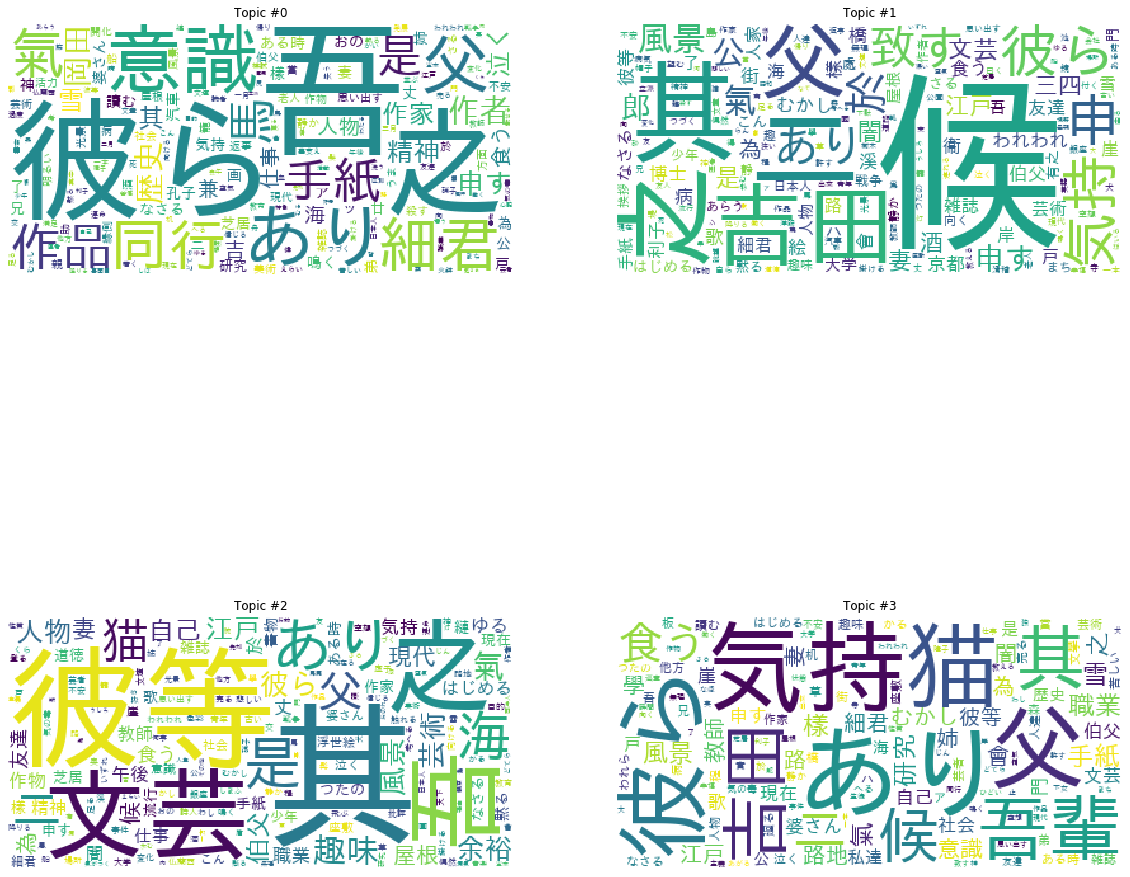

In [60]:
# 備考：WordCloudで可視化
# トピックモデルの場合、トピックごとの単語の生起確率を求めるので、生起確率に基づいてWordcloudが作成できる。
# それら、単語の生起確率で、各トピックがなんのグループ化イメージできる。

plt.figure(figsize=(20,20))
for t in range(4):
    plt.subplot(2, 2, t+1)
    x = dict(lda_model.show_topic(t, 200)) # トピック毎に上位200単語表示
    im = WordCloud(font_path='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf', background_color='white').generate_from_frequencies(x)
    plt.imshow(im)
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.savefig('/content/drive/My Drive/WordCloud.png')
